In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import lightgbm as lgb
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (assuming we've combined the sheets into one DataFrame)
# In practice, you would load the actual CSV file
# df = pd.read_csv('loan_data.csv')

# For this example, I'll create a mock dataframe based on the columns provided
# In a real scenario, you would use the actual data
columns = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
    'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
    'total_acc', 'application_type', 'mort_acc', 'pub_rec_bankruptcies'
]

# Create mock data - in practice, replace with actual data loading
np.random.seed(42)
n_samples = 10000
data = {
    'loan_amnt': np.random.uniform(5000, 35000, n_samples),
    'term': np.random.choice(['36 months', '60 months'], n_samples),
    'int_rate': np.random.uniform(5, 30, n_samples),
    'installment': np.random.uniform(100, 1000, n_samples),
    'grade': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F', 'G'], n_samples),
    'sub_grade': [f"{g}{np.random.randint(1,5)}" for g in np.random.choice(['A', 'B', 'C', 'D', 'E', 'F', 'G'], n_samples)],
    'emp_length': np.random.choice(['<1 year', '1 year', '2 years', '3 years', '4 years', 
                                   '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'], n_samples),
    'home_ownership': np.random.choice(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], n_samples),
    'annual_inc': np.random.uniform(20000, 150000, n_samples),
    'verification_status': np.random.choice(['Verified', 'Not Verified', 'Source Verified'], n_samples),
    'loan_status': np.random.choice(['Fully Paid', 'Charged Off', 'Current', 'Late'], n_samples, p=[0.7, 0.1, 0.15, 0.05]),
    'purpose': np.random.choice(['debt_consolidation', 'credit_card', 'home_improvement', 'other'], n_samples),
    'dti': np.random.uniform(0, 40, n_samples),
    'delinq_2yrs': np.random.randint(0, 5, n_samples),
    'fico_range_low': np.random.randint(600, 750, n_samples),
    'fico_range_high': np.random.randint(650, 800, n_samples),
    'open_acc': np.random.randint(1, 30, n_samples),
    'pub_rec': np.random.randint(0, 5, n_samples),
    'revol_bal': np.random.uniform(0, 50000, n_samples),
    'revol_util': np.random.uniform(0, 100, n_samples),
    'total_acc': np.random.randint(1, 60, n_samples),
    'application_type': np.random.choice(['Individual', 'Joint App'], n_samples, p=[0.9, 0.1]),
    'mort_acc': np.random.randint(0, 5, n_samples),
    'pub_rec_bankruptcies': np.random.randint(0, 3, n_samples)
}

df = pd.DataFrame(data)

# Define default (1) vs non-default (0)
df['default'] = df['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Late'] else 0)

# Feature engineering
df['term'] = df['term'].apply(lambda x: int(x.split()[0]))
df['fico_avg'] = (df['fico_range_low'] + df['fico_range_high']) / 2
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']

# Convert categorical variables
cat_cols = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 
            'verification_status', 'purpose', 'application_type']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Drop unnecessary columns
drop_cols = ['loan_status', 'fico_range_low', 'fico_range_high']
df = df.drop(columns=drop_cols)

# Split data
X = df.drop(columns=['default'])
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 
            'delinq_2yrs', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
            'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'term', 
            'fico_avg', 'loan_to_income']

X_train_smote[num_cols] = scaler.fit_transform(X_train_smote[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [4]:
# LightGBM model with correct parameter usage
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1  # Move verbose parameter here instead of fit()
)

# Create callbacks
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(10)  # This handles the verbose output
]

# Fit the model with correct parameters
lgb_model.fit(
    X_train_smote, 
    y_train_smote,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=callbacks
)

# SVM model (with reduced dataset for practicality)
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    verbose=True  # SVM can take verbose in the constructor
)

# Train on smaller subset due to SVM's computational complexity
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_smote, y_train_smote, train_size=0.3, random_state=42
)
svm_model.fit(X_train_small, y_train_small)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's auc: 0.511218	valid_0's binary_logloss: 0.594918
[20]	valid_0's auc: 0.512421	valid_0's binary_logloss: 0.541302
[30]	valid_0's auc: 0.511302	valid_0's binary_logloss: 0.507182
[40]	valid_0's auc: 0.511733	valid_0's binary_logloss: 0.483737
[50]	valid_0's auc: 0.510509	valid_0's binary_logloss: 0.46983
[60]	valid_0's auc: 0.512298	valid_0's binary_logloss: 0.459545
Early stopping, best iteration is:
[14]	valid_0's auc: 0.516089	valid_0's binary_logloss: 0.569815
[LibSVM]

SVC(probability=True, random_state=42, verbose=True)

In [5]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{model_name} Performance:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    
    return {
        'model': model_name,
        'precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
        'recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
        'f1': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

# Evaluate both models
lgb_metrics = evaluate_model(lgb_model, X_test, y_test, "LightGBM")
svm_metrics = evaluate_model(svm_model, X_test, y_test, "SVM")

# Compare models
results = pd.DataFrame([lgb_metrics, svm_metrics])
print("\nModel Comparison:")
print(results)


LightGBM Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2570
           1       0.19      0.04      0.07       430

    accuracy                           0.84      3000
   macro avg       0.52      0.51      0.49      3000
weighted avg       0.76      0.84      0.79      3000

Confusion Matrix:
[[2496   74]
 [ 413   17]]
ROC AUC Score: 0.5161

SVM Performance:
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      2570
           1       0.11      0.02      0.03       430

    accuracy                           0.84      3000
   macro avg       0.48      0.50      0.47      3000
weighted avg       0.75      0.84      0.79      3000

Confusion Matrix:
[[2514   56]
 [ 423    7]]
ROC AUC Score: 0.4960

Model Comparison:
      model  precision    recall        f1   roc_auc
0  LightGBM   0.186813  0.039535  0.065259  0.516089


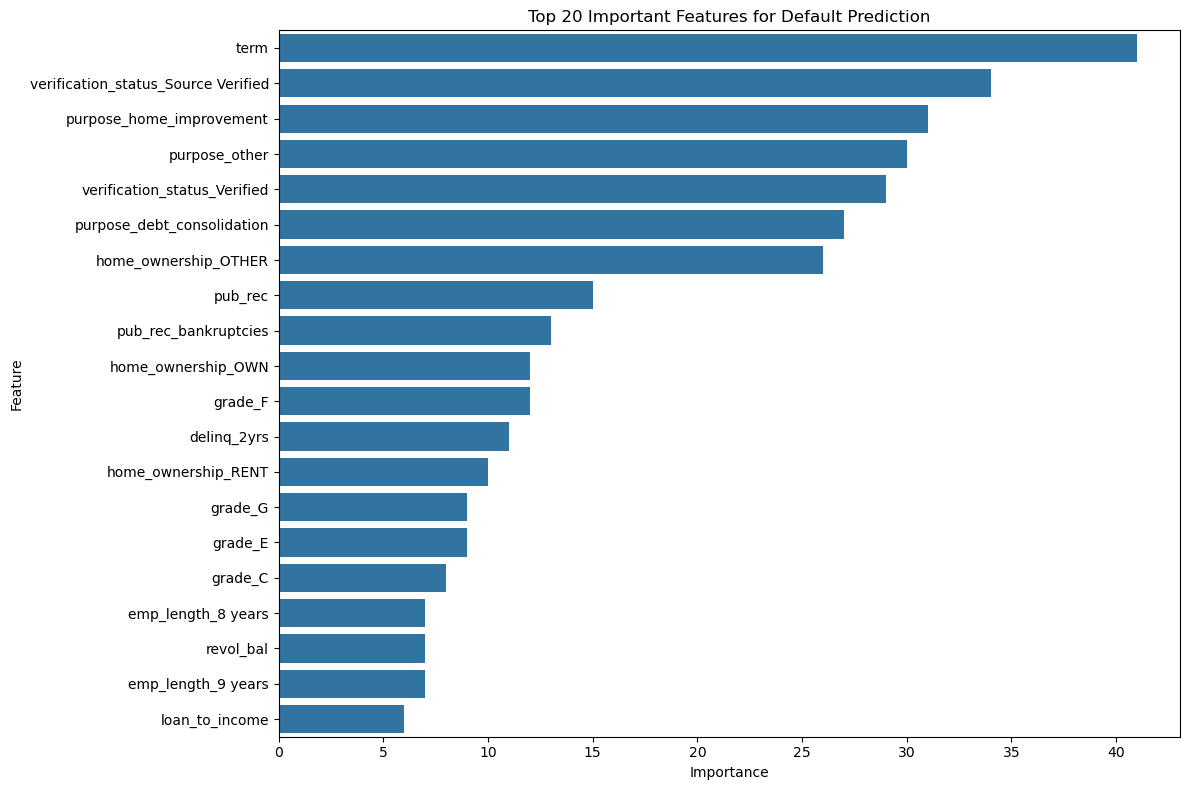

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Important Features for Default Prediction')
plt.tight_layout()
plt.show()